# Install torch 2.3.0 + cu121 to ensure reproducibility

In [1]:
# !pip install torch==2.3.0+cu121 # for reproducibility only

# Get package from GitHub

In [2]:
!git clone https://github.com/zcheng-a/LCD_kNN # load package from github
from LCD_kNN import LCD_kNN as lk

Cloning into 'LCD_kNN'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 93 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (93/93), 7.64 MiB | 6.97 MiB/s, done.
Resolving deltas: 100% (26/26), done.


# Load standard package

In [3]:
### main package
import numpy as np
import torch
print(torch.__version__)
import torch.nn as nn
# import torch.nn.functional as F

### check if device is GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is:', device)
print(torch.cuda.get_device_name(0))

### set seed
np.random.seed(0)
torch.manual_seed(0)

### Auxiliary
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

# Set the custom color cycle for plt.plot
unique_colors =  [
    '#1a6691', '#e5670a', '#268227', '#b52224', '#7d4e99',
    '#774c41', '#c565a1', '#6a6868', '#a1a31d', '#1587af',
    '#43719d', '#d67c4c', '#549456', '#c16d70', '#8c7a9d',
    '#977468', '#d7a2be', '#969696', '#c5c85e', '#4ea9bf'
]

2.3.0+cu121
device is: cuda
NVIDIA L4


# Prepare data

In [4]:
### model parameters
d_X = 3
d_Y = 3
n_mix = 2

A = torch.randn((n_mix, d_Y, d_X), device=device)
B = torch.randn((n_mix, d_Y, d_Y, d_X), device=device)
noise_scale = 0.1 ### governs the scale of torch.randn below



### prepare data
n_data = int(1e6)

x_data = torch.rand(n_data, d_X, device=device) - 0.5
y_data = torch.sin( torch.matmul(A.unsqueeze(0), x_data.unsqueeze(1).unsqueeze(-1)) )[:,:,:,0]
noise = torch.matmul(B.unsqueeze(0), x_data.unsqueeze(1).unsqueeze(-2).unsqueeze(-1))[:,:,:,:,0]
noise = torch.matmul( torch.cos(noise), noise_scale * torch.randn(size=(n_data, 1, d_Y, 1), device=device) )[:,:,:,0]
y_data = y_data + noise
y_data = y_data[ torch.rand(n_data, n_mix, device=device).sort(-1)[1] == 0 ]

data_tensor = torch.cat( (x_data, y_data), 1)

del x_data, noise, y_data
torch.cuda.empty_cache()

# Train StdNet

In [5]:
k = 300
nns_type = 'rbsp'
n_bisect = 5
n_part_batch = 8
bool_sparse = False
n_train = int(1e4)+1

knn_std = lk.LearnCondDistn_kNN(d_X, d_Y, data_tensor)
knn_std.init_net_std(n_atoms=k, n_neurons=2*k, n_layers=5)



optimizer_std = torch.optim.Adam(knn_std.atomnet.parameters(), lr=1e-3)

'Training progress:10000/10000'

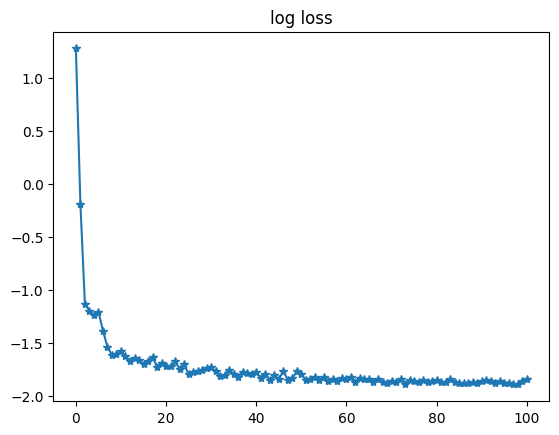

This cell takes 692.79 seconds.
Number of nan loss: 0


In [6]:
time_start = time.time()
loss_lst = []
n_nan = 0
for i in range(n_train):
    knn_std.atomnet.train()

    ### compute loss
    if i <= 100: ### in case of nan
        knn_std.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=5, one_over_eps=1, nns_type=nns_type)
    elif i <= 500:
        knn_std.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=5, one_over_eps=10, nns_type=nns_type)
    else:
        knn_std.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=10, one_over_eps=20, bool_sparse=bool_sparse, gamma_sparse=0.5)

    loss = knn_std.compute_loss()

    ### Step
    if torch.isnan(loss):
        n_nan = n_nan + 1
        continue
    optimizer_std.zero_grad()
    loss.backward()
    optimizer_std.step()

    # print loss
    if i % 100 == 0:
        clear_output(wait=True)
        display('Training progress:' + str(i) + '/' + str(n_train-1))
        # print(i, 'loss:', loss.item())
        # print()
        loss_lst.append(loss.detach().cpu().numpy())

plt.plot(np.log(np.array(loss_lst)), '*-')
plt.title('log loss')
plt.show()
time_end = time.time()
print("This cell takes %.2f seconds." % (time_end-time_start))
print("Number of nan loss: " + str(n_nan))
del loss

# Train LipNet

In [7]:
k = 300
nns_type = 'rbsp'
L = 0.1
tau = 1e-3
bool_sparse = False
gamma_sparse = 0.5
n_bisect = 5
n_part_batch = 8
bool_sparse = False
n_train = int(1e4)+1

knn_lip = lk.LearnCondDistn_kNN(d_X, d_Y, data_tensor)
knn_lip.init_net_lip(n_atoms=k, n_neurons=2*k, n_layers=5, L=0.1, input_actvn=nn.ELU(), hidden_actvn=nn.ELU(), L_requires_grad=False)

if knn_lip.atomnet.L.requires_grad:
    optimizer_lip = torch.optim.Adam([
        {'params': knn_lip.atomnet.input_fc.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.hidden_layers.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.output_fc.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.L, 'lr': 1e-2}
        ])
else:
    optimizer_lip = torch.optim.Adam(knn_lip.atomnet.parameters(), lr=1e-3)

'Training progress:10000/10000'

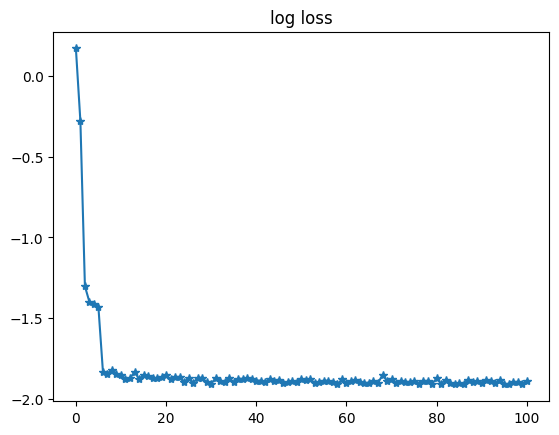

This cell takes 722.13 seconds.
Number of nan loss: 22


In [8]:
time_start = time.time()
loss_lst = []
n_nan = 0
for i in range(n_train):
    knn_lip.atomnet.train()

    ### compute loss
    if i <= 100: ### in case of nan
        knn_lip.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=5, one_over_eps=1, nns_type=nns_type)
    elif i <= 500:
        knn_lip.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=5, one_over_eps=10, nns_type=nns_type)
    else:
        knn_lip.set_compute_loss_param(k, n_bisect=n_bisect, n_part_batch=n_part_batch, n_iter_skh=10, one_over_eps=20, bool_sparse=bool_sparse, nns_type=nns_type)

    loss = knn_lip.compute_loss()

    ### Step
    if torch.isnan(loss):
        n_nan = n_nan + 1
        continue
    optimizer_lip.zero_grad()
    loss.backward()
    optimizer_lip.step()
    if knn_lip.lip_bool:
        knn_lip.atomnet.update_nor(mmt_inoutweight=1e-3, mmt_uh=1e-3, p_update=1)

    # print loss
    if i % 100 == 0:
        clear_output(wait=True)
        display('Training progress:' + str(i) + '/' + str(n_train-1))
        # print(i, 'loss:', loss.item())
        # print()
        loss_lst.append(loss.detach().cpu().numpy())

plt.plot(np.log(np.array(loss_lst)), '*-')
plt.title('log loss')
plt.show()

time_end = time.time()
print("This cell takes %.2f seconds." % (time_end-time_start))
print("Number of nan loss: " + str(n_nan))
del loss

# Plot projected CDFs and trajectories of atoms

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2

Evaluated at x = array([ 0.12, -0.33,  0.1 ], dtype=float32)
Absolute divergence of StdNet:6.680591583251953
Absolute divergence of LipNet:6.979409217834473


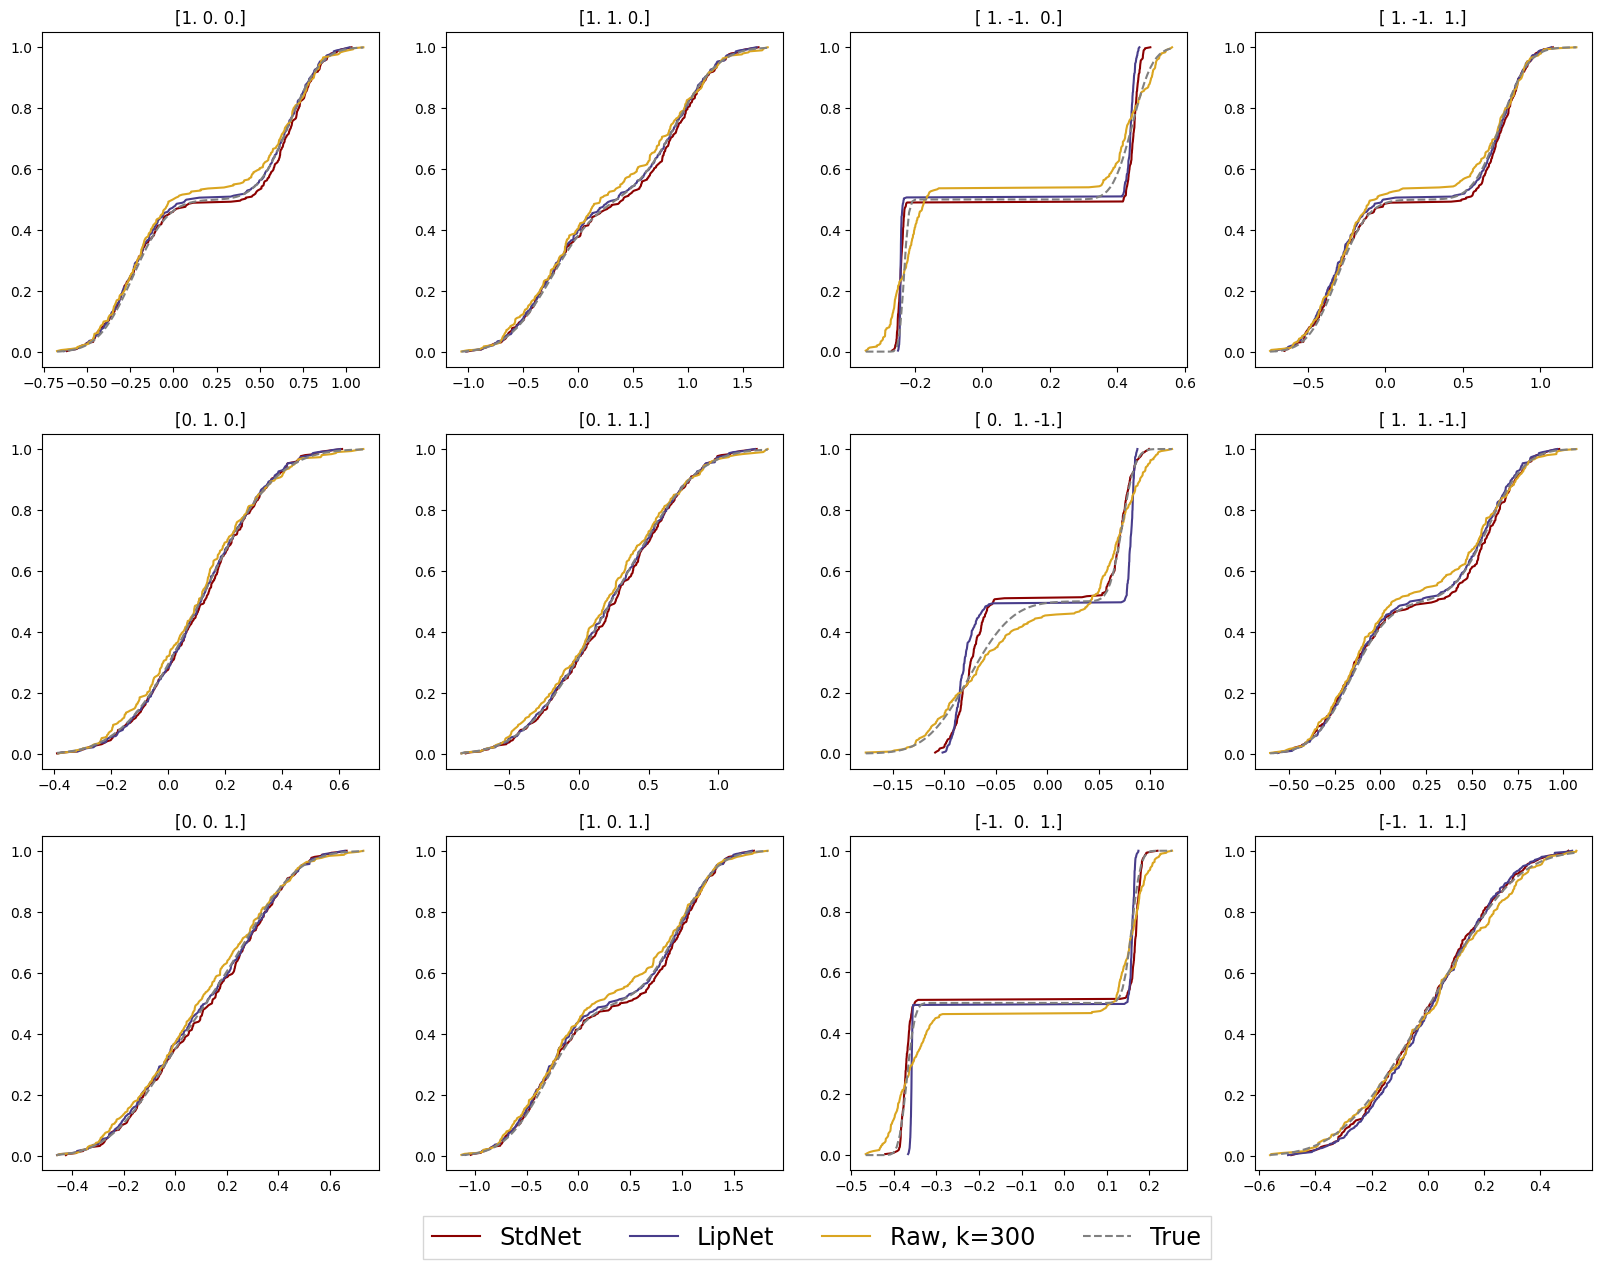

Atom Traj. of StdNet


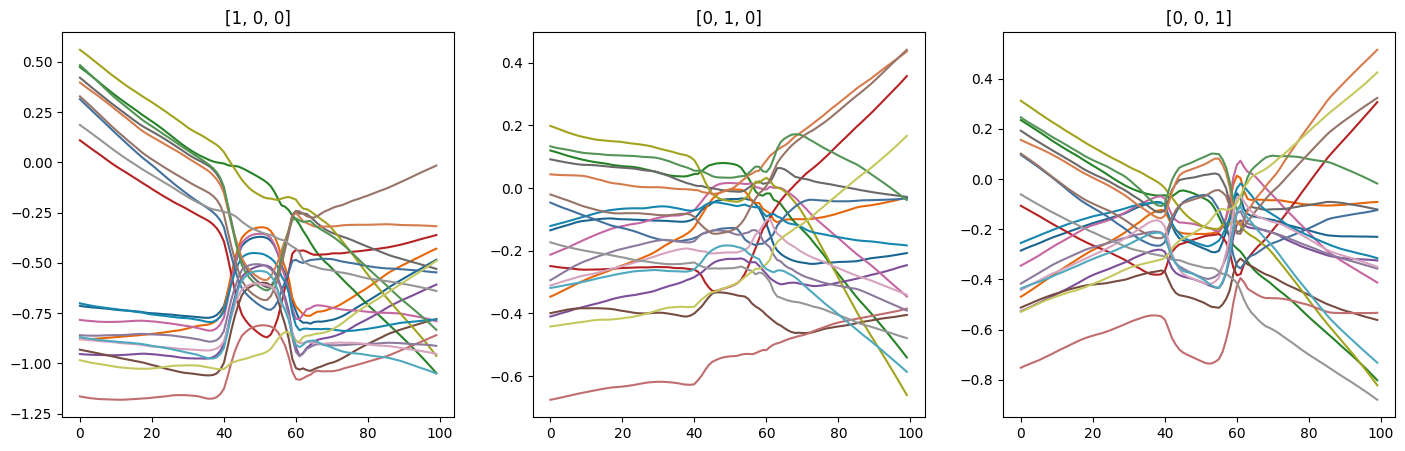

Atom Traj. of LipNet


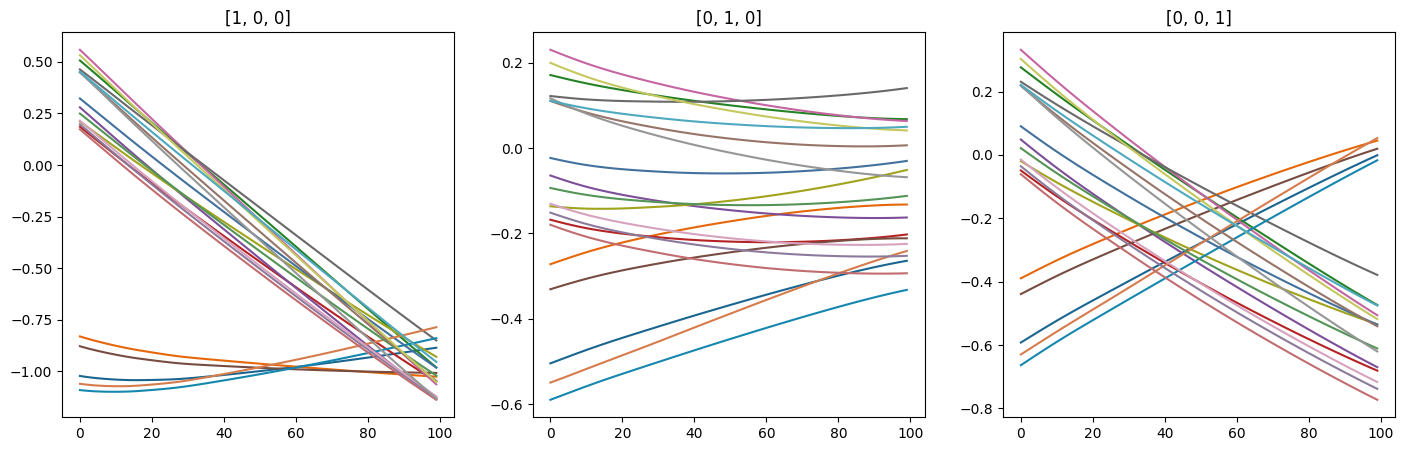

In [10]:
k_plot_vec = [k] ### change k here to see impact of k on empirical measures, e.g., [1000, 3000, int(1e4)]
x = torch.tensor([[ 0.12, -0.33,  0.10]], device=device) ### for reproducibility
# x = torch.rand(1, d_X, device=device) - 0.5

# compuate required outcomes
x.requires_grad = True
knn_std.atomnet.eval()
y_std = knn_std.atomnet(x)
y_lip = knn_lip.atomnet(x)
indx_near = torch.sum(torch.abs(data_tensor[:,:d_X] - x),-1).sort()[1]

# print related stuff
print("Evaluated at x = " + repr(x[0].detach().cpu().numpy()))

div_abs = 0
for d in range(d_X):
    for i in range(knn_std.atomnet.n_atoms):
        div_abs += torch.abs(torch.autograd.grad(y_std[0,i,d], x, create_graph=False, retain_graph=True)[0])
div_abs = div_abs.sum() / knn_std.atomnet.n_atoms
print("Absolute divergence of StdNet:" + str(div_abs.item()))

div_abs = 0
for d in range(d_X):
    for i in range(knn_lip.atomnet.n_atoms):
        div_abs += torch.abs(torch.autograd.grad(y_lip[0,i,d], x, create_graph=False, retain_graph=True)[0])
div_abs = div_abs.sum() / knn_lip.atomnet.n_atoms
print("Absolute divergence of LipNet:" + str(div_abs.item()))
# if knn_lip.atomnet.L.requires_grad:
#    print("L = " + str(knn_lip.atomnet.lip.data.detach().cpu().numpy()))

# vectors for projection
vec = torch.tensor([
    [1,0,0], [1,1,0], [1,-1,0], [1,-1,1],
    [0,1,0], [0,1,1], [0,1,-1], [1,1,-1],
    [0,0,1], [1,0,1], [-1,0,1], [-1,1,1]
                    ], dtype=torch.float, device=device)

# prepare subplots
plt.rcdefaults()
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 4, wspace=0.2, hspace=0.2)
for i_v in range(len(vec)):
    exec("ax"+str(i_v)+" = fig.add_subplot(gs["+str(i_v)+"])")


# plot projected conditional cdfs
for i_v in range(len(vec)):
    ax_name = "ax" + str(i_v)
    eval(ax_name + ".title.set_text(str(vec[i_v].detach().cpu().numpy()))")

    ## plot cdf according to StdNet
    n_atoms = knn_std.atomnet.n_atoms
    atoms_stdnet = torch.matmul(y_std[0], vec[i_v].view(-1,1))
    atoms_stdnet = atoms_stdnet[:,0].sort()[0]
    eval(ax_name + ".plot(atoms_stdnet.detach().cpu().numpy(), np.arange(n_atoms+1)[1:]/n_atoms,  color='darkred', label='StdNet')")

    ## plot cdf according to LipNet
    n_atoms = knn_lip.atomnet.n_atoms
    atoms_lipnet = torch.matmul(y_lip[0], vec[i_v].view(-1,1))
    atoms_lipnet = atoms_lipnet[:,0].sort()[0]
    eval(ax_name + ".plot(atoms_lipnet.detach().cpu().numpy(), np.arange(n_atoms+1)[1:]/n_atoms,  color='darkslateblue', label='LipNet')")

    ## plot cdf according to raw estiamtor used in training
    for k_plot in k_plot_vec:
        y_near = data_tensor[indx_near[:k_plot]][:, d_X:]
        atoms_emp = torch.matmul(y_near, vec[i_v].view(-1,1))
        atoms_emp = atoms_emp[:,0].sort()[0]
        if len(k_plot_vec) == 1:
            eval(ax_name + ".plot(atoms_emp.detach().cpu().numpy(), np.arange(k_plot+1)[1:]/k_plot, color='goldenrod', label='Raw, k='+str(k_plot_vec[0]))")
        else: ### not a good plot
            color = np.random.rand(4) *  np.array([0.9, 0.9, 0.9, 1])
            eval(ax_name + ".plot(atoms_emp.detach().cpu().numpy(), np.arange(k_plot+1)[1:]/k_plot, color=color, label='Raw, k='+str(k_plot))")

    ## plot cdf according to model
    x_left, x_right = -max(-atoms_emp[0], -atoms_stdnet[0], -atoms_lipnet[0]), max(atoms_emp[-1], atoms_stdnet[-1], atoms_lipnet[-1])
    x_plot = torch.linspace(float(x_left), float(x_right), 100, device=device)
    A_x0 = torch.matmul(A, x.view(-1,1))[:,:,0]
    B_x0 = torch.matmul(B, x.view(1,-1,1))[:,:,:,0]
    mean = torch.sum(torch.sin(A_x0) * vec[i_v], -1)
    std = noise_scale * torch.matmul( torch.cos(B_x0).transpose(-2,-1), vec[i_v] ).square().sum(-1).sqrt()
    cdf = torch.distributions.normal.Normal(loc=mean, scale=std).cdf
    y_plot = torch.sum(cdf(x_plot.view(-1,1)), -1) / n_mix
    eval(ax_name + ".plot(x_plot.detach().cpu().numpy(), y_plot.detach().cpu().numpy(), '--',  color='grey', label='True')")



ax10.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.1), fancybox=False, shadow=False, ncol=10, fontsize='xx-large')
plt.show()




# plot projected trajectories of atoms
n_plot = 100
n_atom_plot = 20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=unique_colors)
x_ = x / torch.max(torch.abs(x)) * 0.5
x_line = -x_.repeat(n_plot, 1) + x_.abs().repeat(n_plot,1) * torch.linspace(0, 2, 100, device=device).view(-1, 1)
y_line_std = knn_std.atomnet(x_line)
y_line_lip = knn_lip.atomnet(x_line)

## plot according to StdNet
print("Atom Traj. of StdNet")
fig_atom_std = plt.figure(figsize=(17.2, 5))
gs_atom_std = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)
for i_d in range(d_Y):
    exec("ax_atom_std"+str(i_d)+" = fig_atom_std.add_subplot(gs_atom_std["+str(i_d)+"])")

for i_d in range(d_Y):
    ax_name = "ax_atom_std" + str(i_d)
    temp = [0, 0, 0]
    temp[i_d] = 1
    eval(ax_name + ".title.set_text(str(temp))")
    for i_atom in range(n_atom_plot):
        y_plot = y_line_std[:,i_atom,i_d].detach().cpu().numpy()
        eval(ax_name + ".plot(y_plot)")
plt.show()

## plot_according to LipNet
print("Atom Traj. of LipNet")
fig_atom_lip = plt.figure(figsize=(17.2, 5))
gs_atom_lip = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)
for i_d in range(d_Y):
    exec("ax_atom_lip"+str(i_d)+" = fig_atom_lip.add_subplot(gs_atom_lip["+str(i_d)+"])")

for i_d in range(d_Y):
    ax_name = "ax_atom_lip" + str(i_d)
    temp = [0, 0, 0]
    temp[i_d] = 1
    eval(ax_name + ".title.set_text(str(temp))")
    for i_atom in range(n_atom_plot):
        y_plot = y_line_lip[:,i_atom,i_d].detach().cpu().numpy()
        eval(ax_name + ".plot(y_plot)")
plt.show()

# Plot histograms of projected W errors

In [11]:
time_start = time.time()

N_q = int(1e4)
x_q = torch.rand(N_q, d_X, device=device) - 0.5

# prepare atoms from raw k-NN estimator
k_lst = [300, 1000, 3000, 10000]
atoms_raw = []
for k_ in k_lst:
    atoms_raw.append(torch.zeros(size=[N_q, k_, d_X],device=device))
for i in range(N_q):
    indx_temp = (data_tensor[:,:d_X] - x_q[i].view(1,-1)).abs().sum(-1).sort(-1)[1]
    for j in range(len(k_lst)):
        k_ = k_lst[j]
        atoms_raw[j][i] = data_tensor[indx_temp[:k_], d_X:]

# prepare atoms from net
with torch.no_grad():
    y_std = knn_std.atomnet(x_q)
    y_lip = knn_lip.atomnet(x_q)

# prepare vectors for pojection
unif_simplex = torch.distributions.dirichlet.Dirichlet(torch.ones(d_X, device=device))
vec = unif_simplex.rsample(sample_shape=[N_q])
# angel_1 = torch.rand(size=[N_q,1], device=device)
# angel_2 = torch.rand(size=[N_q,1], device=device)
# vec = torch.cat((torch.sin(angel_1)*torch.cos(angel_2), torch.sin(angel_1)*torch.sin(angel_2), torch.cos(angel_1)), dim=-1)

# prepare mean and std for true cdf
mean = torch.sum(torch.sin( torch.matmul(A.unsqueeze(0), x_q.unsqueeze(1).unsqueeze(-1)) )[:,:,:,0] * vec.unsqueeze(1), -1)
std = torch.matmul(B.unsqueeze(0), x_q.unsqueeze(1).unsqueeze(-2).unsqueeze(-1))[:,:,:,:,0]
std = noise_scale * torch.matmul( torch.cos(std).transpose(-2,-1), vec.unsqueeze(1).unsqueeze(-1) )[:,:,:,0].square().sum(-1).sqrt()

# collect projected W errors
proj_W_all = []
for _ in range(len(k_lst)+2):
    proj_W_all.append(torch.zeros(N_q, device=device))

def compute_proj_W(atoms_, vec_, proj_cdf_, n_mix=n_mix, n_int=10000, device=device):
    proj_atoms_ = (atoms_ * vec_.view(1,-1)).sum(-1).sort()[0]
    y_int = torch.linspace(proj_atoms_[0], proj_atoms_[-1], n_int, device=device)
    proj_cdf_true = proj_cdf(y_int.view(-1,1)).sum(-1) / n_mix
    proj_cdf_est = (proj_atoms_.view(1,-1) <= y_int.view(-1,1)).sum(-1) / atoms_.shape[0]
    ## trapzoidal
    abs_diff = (proj_cdf_est - proj_cdf_true).abs()
    return ((abs_diff[:-1] + abs_diff[1:])).sum() / 2 / n_int * (proj_atoms_[-1] - proj_atoms_[0])

for i in range(N_q):
    if (i+1) % 100 == 0:
        clear_output(wait=True)
        display('Projected W error compuations:' + str(i+1) + '/' + str(N_q))
    proj_cdf = torch.distributions.normal.Normal(loc=mean[i], scale=std[i]).cdf
    for j in range(len(k_lst)):
        proj_W_all[j][i] = compute_proj_W(atoms_raw[j][i], vec[i], proj_cdf)
    proj_W_all[-2][i] = compute_proj_W(y_std[i], vec[i], proj_cdf)
    proj_W_all[-1][i] = compute_proj_W(y_lip[i], vec[i], proj_cdf)

time_end = time.time()
print("This cell takes %.2f seconds." % (time_end-time_start))


'Projected W error compuations:10000/10000'

This cell takes 138.56 seconds.


Hisitongams of raw estimators in k_lst is plotted first, then stdnet, then lipnet.

[   3  810 2265 2082 1437  955  693  460  335  263  169  136  106   78
   49   41   32   16    9   61]



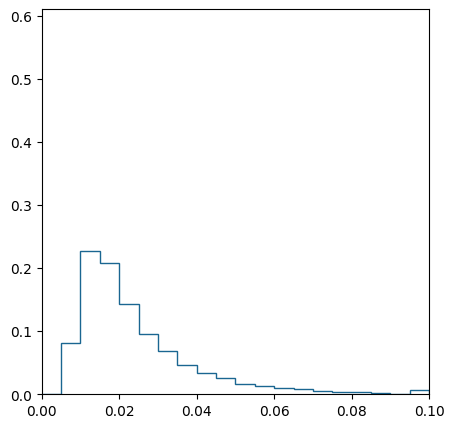

[ 236 3219 3018 1556  862  503  273  130   98   47   25   20    8    1
    2    1    0    0    1    0]



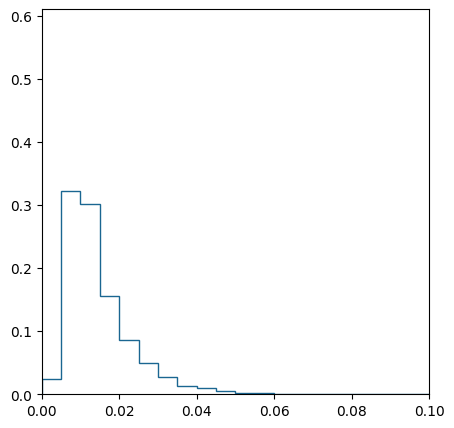

[ 284 3426 3176 1571  716  382  201  131   61   31   14    4    1    1
    1    0    0    0    0    0]



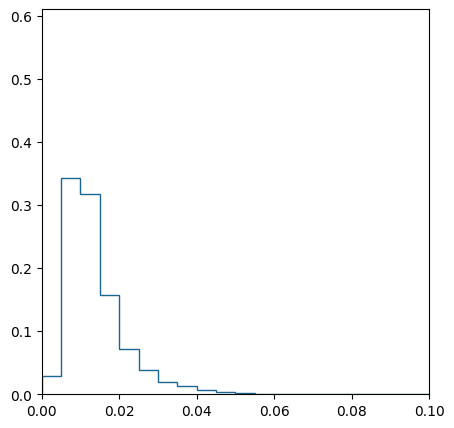

[   0  569 2241 2159 1584 1083  741  529  366  259  181  128   56   42
   28   13    9    5    2    5]



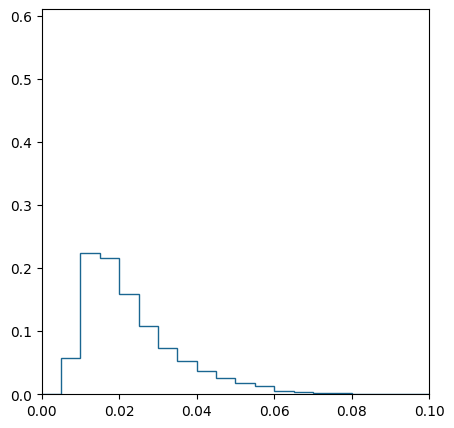

[ 533 3683 2255 1553  941  480  268  111   76   52   25   10    7    3
    1    1    0    1    0    0]



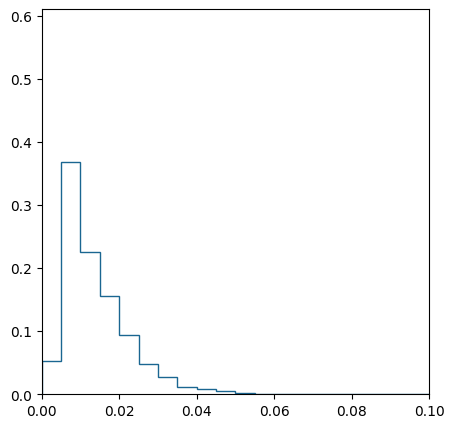

[1213 3001 2738 1644  918  361   87   19    5    3    2    0    0    0
    0    2    0    2    0    5]



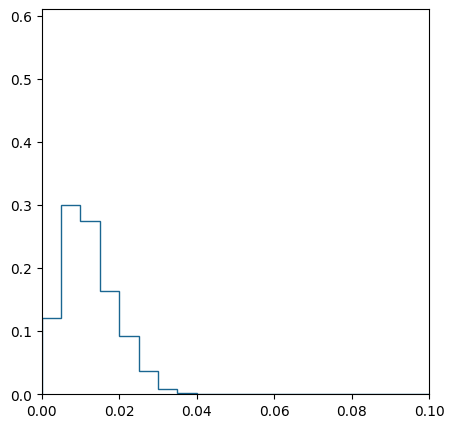

In [12]:
print("Hisitongams of raw estimators in k_lst is plotted first, then stdnet, then lipnet.\n")
bins = np.arange(21) / 20 * 0.1
bins[-1] = 1
bins_plot = np.arange(21) / 20 * 0.1
for proj_W in proj_W_all:
    counts, _ = np.histogram(proj_W.detach().cpu().numpy(), bins=bins)
    print(counts)
    # print(bins)
    print()
    plt.figure(figsize=(5,5))
    plt.stairs(counts/N_q, bins_plot)
    plt.xlim([0,0.1])
    plt.ylim([0,0.61])
    plt.show()